## Task to be acheived:

Data Augmentation Framework for Image,Audio,and Text Data Corpora
– Motivation:Data-Independent,generic,and embedded data augmentation pipeline,usable
as a data enrichment process for any machine and/or deep learning model.
– Methods:Research on different existing augmentation techniques for image,acoustic and/or text signals.

– Goal: Stand-alone Python module which allows to select from a pool of data-specific augmentation techniques as stand-alone functions, to build an entire data augmentation pipe- line.

## How to run the code
To run the code please change the path in sys.insert and also in the config folder.
Dependenies are mentioned in requirements.txt.
Ensure to create virtual enviroment and install all the dependencies.
Please specify the config path here and name of the technique you want to run
config_file = "/home/bcae/AI_Project/AI_project/config/Config.Json"
technique = "text"  # Change this to 'audio', 'image', 'sensor', or 'all' as needed

Input files need to be placed in the input folder of the package.

All the source files are in src folder.

Once you run the cell of main function all other dependent notebooks will be imported and executed and then 
Outputs will get saved into : "augmented_data" folder.

For text:
If you want to run with some other text file. You need to mention the text column name in config so that it will get saved.

## Libraries which needs to be installed:
pandas==2.2.2
soundfile==0.12.1
playsound==1.3.0
torch==2.3.1
PyObjC
librosa==0.10.2
IPython==8.25.0
transformers==4.41.2
wordcloud==1.9.3
nltk==3.8.1
contractions==0.1.73
emoji==2.12.1
googletrans==3.0.0
torchvision==0.18.1
pydub==0.25.1

Also mentioned in requirements.txt.
Execute pip install -r requirements.txt
    


## Overview of the below code
Functions:
process_text(config_data):

Purpose: Processes text data by applying preprocessing and augmentation techniques.
Steps:
Initialize text preprocessing and augmentation objects.
Preprocess the data and validate its format.
Apply augmentation techniques to the preprocessed data.
Save the augmented data to the specified output path.
Exceptions: Handles PermissionError, generic exceptions, and validates the DataFrame format.
process_audio(config_data):

Purpose: Processes audio data by applying augmentation techniques.
Steps:
Load the audio file from the input path.
Play the original audio.
Apply augmentation techniques to the audio.
Save and play the augmented audio.
Exceptions: Handles PermissionError, FileNotFoundError, and generic exceptions.
process_image(config_data):

Purpose: Processes image data by applying augmentation techniques.
Steps:
Load image data and apply base and augmentation transformations.
Save the augmented images to the specified output path.
Exceptions: Handles generic exceptions during image processing.
process_sensor_data(config_data):

Purpose: Processes sensor data by applying augmentation techniques.
Steps:
Load the sensor data file.
Separate columns to exclude from augmentation.
Apply augmentation techniques to the relevant data.
Save the augmented data to the specified output path.
Exceptions: Handles PermissionError, FileNotFoundError, pd.errors.EmptyDataError, pd.errors.ParserError, and generic exceptions.
main(config_file, technique):

Purpose: The entry point for running the data augmentation pipeline.
Steps:
Load the configuration file.
Depending on the specified technique ('text', 'audio', 'image', 'sensor', or 'all'), call the appropriate processing function(s).
Exceptions: Handles json.JSONDecodeError and generic exceptions.

In [ ]:
# Install this libraries to import notebooks correctly in the files
!pip install import-ipynb
!pip install nbimporter

In [4]:
import json
import argparse
import os
import pandas as pd
import soundfile as sf
import playsound
import sys
import import_ipynb
sys.path.insert(0, '/home/bcae/AI_Project/AI_project/src')
from src.text.Text_Augmentation import TextAugmentation
from src.text.Text_Processing import TextPreprocessing
from src.Audio.Audio_Augmentation import AudioAugmentor
from src.img_aug.img_aug import AugmentedDataset
from src.Sensor_aug.sensor_aug import SensorAugmentation
from config.config_loader import load_config

def process_text(config_data):
    """
    Process text data according to the configuration.

    Args:
        config_data (dict): Configuration data containing paths and settings for text augmentation.

    Returns:
        None

    Raises:
        PermissionError: If there are issues with file permissions.
        Exception: For any other exceptions.
    """
    try:
        text_columns = config_data["data_augmentation"]["text_augmentation"]["text_columns"]

        # Initialize text preprocessing and augmentation
        text_pre_obj = TextPreprocessing(config_data)
        preprocessed_df = text_pre_obj.start_preprocessing()

        if not isinstance(preprocessed_df, pd.DataFrame):
            raise ValueError("Preprocessed data should be a DataFrame.")

        print("Preprocessed Data:")
        print(preprocessed_df)
        print("Shape of preprocessed data:", preprocessed_df.shape)

        text_augmentor = TextAugmentation(config_data["data_augmentation"]["text_augmentation"])
        augmented_data = text_augmentor.start_augmentation_process(preprocessed_df, text_columns)

        output_path = os.path.join(config_data["data"]["base_output_path"], config_data["data_augmentation"]["text_augmentation"]["output_path"])
        print("File saved in:" ,output_path)
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        augmented_data.to_csv(os.path.join(output_path, "augmented_data.csv"), index=False)
        print("Shape of augmented data:", augmented_data.shape)

    except PermissionError as e:
        print(f"PermissionError: {e}. Ensure the file path is correct and you have the required permissions.")
    except Exception as e:
        print(f"An error occurred: {e}")

def process_audio(config_data):
    """
    Process audio data according to the configuration.

    Args:
        config_data (dict): Configuration data containing paths and settings for audio augmentation.

    Returns:
        None

    Raises:
        PermissionError: If there are issues with file permissions.
        FileNotFoundError: If the audio file is not found at the specified path.
        Exception: For any other exceptions.
    """
    try:
        input_path = os.path.join(config_data["data"]["base_input_path"],
                                  config_data["data_augmentation"]["audio_augmentation"]["file_path"])
        output_path = os.path.join(config_data["data"]["base_output_path"],
                                   config_data["data_augmentation"]["audio_augmentation"]["output_path"])

        audio_augmentor = AudioAugmentor(config_data['data_augmentation']['audio_augmentation'])
        sample_rate = config_data['data_augmentation']['audio_augmentation']['sample_rate']

        if not os.path.exists(input_path):
            raise FileNotFoundError(f"Audio file not found at {input_path}")

        audio, sr = audio_augmentor.load_audio(input_path, sample_rate)

        print("Playing original audio...")
        temp_original_filename = "temp_original_audio.wav"
        sf.write(temp_original_filename, audio.numpy(), sr)
        playsound.playsound(temp_original_filename)
        os.remove(temp_original_filename)

        augmented_audios = audio_augmentor.apply_augmentation(audio, sr)

        if not os.path.exists(output_path):
            os.makedirs(output_path)

        for technique, augmented_audio in augmented_audios.items():
            save_path = os.path.join(output_path, f"augmented_audio_{technique}.wav")
            audio_augmentor.save_audio(augmented_audio, save_path, sr)
            print(f"Playing augmented audio: {technique}")
           
            playsound.playsound(save_path)
        print("File saved in:" ,output_path)
    except PermissionError as e:
        print(f"PermissionError: {e}. Ensure the file path is correct and you have the required permissions.")
    except FileNotFoundError as e:
        print(f"FileNotFoundError: {e}. Ensure the audio file exists at the specified path.")
    except Exception as e:
        print(f"An error occurred: {e}")

def process_image(config_data):
    """
    Process image data according to the configuration.

    Args:
        config_data (dict): Configuration data containing paths and settings for image augmentation.

    Returns:
        None

    Raises:
        Exception: For any exceptions during the image processing.
    """
    try:
        input_path = os.path.join(config_data["data"]["base_input_path"],
                                  config_data["data_augmentation"]["image_augmentation"]["file_path"])
        output_path = os.path.join(config_data["data"]["base_output_path"],
                                   config_data["data_augmentation"]["image_augmentation"]["output_path"])

        base_transform, aug_transforms = load_config(config_data)[3:]

        img_pre_obj = AugmentedDataset(data_path=input_path, base_transform=base_transform,
                                       aug_transforms=aug_transforms)

        if not os.path.exists(output_path):
            os.makedirs(output_path)
        img_pre_obj.aug_img_dir(directory=output_path)
        print("File saved in:" ,output_path)
    except Exception as e:
        print(f"An error occurred: {e}")


def process_sensor_data(config_data):
    """
    Process sensor data according to the configuration.

    Args:
        config_data (dict): Configuration data containing paths and settings for sensor data augmentation.

    Returns:
        None

    Raises:
        PermissionError: If there are issues with file permissions.
        FileNotFoundError: If the sensor data file is not found at the specified path.
        pd.errors.EmptyDataError: If the data file is empty.
        pd.errors.ParserError: If there is an error parsing the data file.
        Exception: For any other exceptions.
    """
    try:
        input_path = os.path.join(config_data["data"]["base_input_path"],
                                  config_data["data_augmentation"]["sensor_augmentation"]["script_path"])
        output_path = os.path.join(config_data["data"]["base_output_path"],
                                   config_data["data_augmentation"]["sensor_augmentation"]["output_path"])
        exclude_columns = config_data["data_augmentation"]["sensor_augmentation"].get("exclude_columns", [])

        if not os.path.exists(input_path):
            raise FileNotFoundError(f"Sensor data file not found at {input_path}")

        print(f"Loading sensor data from {input_path}...")
        original_df = pd.read_csv(input_path)
        if 'Unnamed: 0' in original_df.columns:
            original_df = original_df.drop(columns=['Unnamed: 0'])

        # Separate the columns to exclude from the rest of the data
        excluded_data = original_df[exclude_columns].reset_index(drop=True)
        data_to_augment = original_df.drop(columns=exclude_columns).reset_index(drop=True)

        print("Data loaded successfully. Sample data:")
        print(original_df.columns)
        print(original_df.head())  # Print first 5 rows for verification

        augmenter = SensorAugmentation(config_data["data_augmentation"]["sensor_augmentation"]["techniques"])
        augmented_data = augmenter.augment_data(data_to_augment.to_numpy(),
                                                config_data["data_augmentation"]["sensor_augmentation"]["techniques"])
        
    
        print("File saved in:" ,output_path)
        
        if isinstance(augmented_data, dict):
            print("Augmented data keys:", list(augmented_data.keys()))
            for key in augmented_data.keys():
                print(f"Augmented data sample for {key}:")
                print(augmented_data[key][:5])  # Print first 5 rows for verification
        else:
            if len(augmented_data) == 0:
                raise ValueError("Augmented data is empty. Please check the augmentation process.")
            print("Augmented data sample:", augmented_data[:5])  # Print first 5 rows for verification

        # Ensure augmented_data is correctly converted to DataFrame if it's not a dict
        if isinstance(augmented_data, dict):
            # Assuming we need to handle multiple augmentations from the dict
            augmented_dfs = []
            for key, value in augmented_data.items():
                augmented_df = pd.DataFrame(value, columns=data_to_augment.columns)
                # Add excluded columns back
                final_augmented_df = pd.concat([excluded_data, augmented_df.reset_index(drop=True)], axis=1)
                augmented_dfs.append((key, final_augmented_df))
        else:
            augmented_df = pd.DataFrame(augmented_data, columns=data_to_augment.columns)
            # Add excluded columns back
            final_augmented_df = pd.concat([excluded_data, augmented_df.reset_index(drop=True)], axis=1)
            augmented_dfs = [("default", final_augmented_df)]

        if not os.path.exists(output_path):
            os.makedirs(output_path)

        base_filename = os.path.splitext(os.path.basename(input_path))[0]

        for technique, df in augmented_dfs:
            augmented_file_path = os.path.join(output_path, f"{base_filename}_augmented_{technique}.csv")
            df.to_csv(augmented_file_path, index=False)

        augmented_files = [f for f in os.listdir(output_path) if
                           f.endswith('.csv') and os.path.isfile(os.path.join(output_path, f))]
        for file in augmented_files:
            file_path = os.path.join(output_path, file)
            try:
                augmented_df = pd.read_csv(file_path)
                print(f"Shape of augmented data from {file}: {augmented_df.shape}")
            except UnicodeDecodeError as e:
                print(
                    f"UnicodeDecodeError: {e}. Could not read the file {file_path}. It might be encoded in a non-UTF-8 format.")
            except Exception as e:
                print(f"An error occurred while reading the file {file_path}: {e}")

    except PermissionError as e:
        print(f"PermissionError: {e}. Ensure the file path is correct and you have the required permissions.")
    except FileNotFoundError as e:
        print(f"FileNotFoundError: {e}. Ensure the sensor data file exists at the specified path.")
    except pd.errors.EmptyDataError as e:
        print(f"EmptyDataError: {e}. The data file is empty.")
    except pd.errors.ParserError as e:
        print(f"ParserError: {e}. Error parsing the data file.")
    except Exception as e:
        print(f"An error occurred: {e}")


def main(config_file, technique):
    """
    Main function to run the data augmentation pipeline.

    Args:
        config_file (str): Path to the configuration file.
        technique (str): Technique to use for augmentation ('text', 'audio', 'image', 'sensor', or 'all').

    Returns:
        None

    Raises:
        json.JSONDecodeError: If there is an error decoding the JSON configuration file.
        Exception: For any other exceptions.
    """
    try:
        with open(config_file, 'rb') as f:
            raw_data = f.read()
            config = json.loads(raw_data.decode('utf-8'))

        if technique == 'text':
            if "text_augmentation" in config["data_augmentation"]:
                process_text(config)
        elif technique == 'audio':
            if "audio_augmentation" in config["data_augmentation"]:
                process_audio(config)
        elif technique == 'image':
            if "image_augmentation" in config["data_augmentation"]:
                process_image(config)
        elif technique == 'sensor':
            if "sensor_augmentation" in config["data_augmentation"]:
                process_sensor_data(config)
        elif technique == 'all':
            if "text_augmentation" in config["data_augmentation"]:
                process_text(config)
            if "audio_augmentation" in config["data_augmentation"]:
                process_audio(config)
            if "image_augmentation" in config["data_augmentation"]:
                process_image(config)
            if "sensor_augmentation" in config["data_augmentation"]:
                process_sensor_data(config)
        else:
            print("Invalid technique. Please enter 'text', 'audio', 'image', 'sensor', or 'all'.")
    except json.JSONDecodeError as e:
        print(f"JSON Decode Error: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

# For Jupyter notebook, set the config file and technique directly
config_file = "/home/bcae/AI_Project/AI_project/config/Config.Json"
technique = "text"  # Change this to 'audio', 'image', 'sensor', or 'all' as needed

main(config_file, technique)


playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


importing Jupyter notebook from /home/bcae/AI_Project/AI_project/src/text/Text_Augmentation.ipynb
importing Jupyter notebook from /home/bcae/AI_Project/AI_project/src/text/Text_Processing.ipynb
importing Jupyter notebook from /home/bcae/AI_Project/AI_project/src/Audio/Audio_Augmentation.ipynb
importing Jupyter notebook from /home/bcae/AI_Project/AI_project/src/img_aug/img_aug.ipynb


[nltk_data] Downloading package wordnet to /home/bcae/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


importing Jupyter notebook from /home/bcae/AI_Project/AI_project/src/Sensor_aug/sensor_aug.ipynb
importing Jupyter notebook from /home/bcae/AI_Project/AI_project/config/config_loader.ipynb
/home/bcae/AI_Project/AI_project/input_data/text/Reviews.csv
Dataset created
Dataset filtered


2024-07-01 21:56:23.458862: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 21:56:23.458900: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 21:56:23.458932: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 21:56:23.465953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Text preprocessing applied
Preprocessed Data:
                                     Sentence
0                       good quality dog food
1                           not as advertised
2                        delight  says it all
3                              cough medicine
4                                 great taffy
5                                  nice taffy
6  great just as good as the expensive brands
7                       wonderful tasty taffy
8                                  yay barley
9                            healthy dog food
Shape of preprocessed data: (10, 1)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


File saved in: /home/bcae/AI_Project/AI_project/augmented_data/text
Shape of augmented data: (10, 17)


## For visualisation

## Image

Selected image names: ['Lion_RandomHorizontalFlip.jpeg', 'jaguar_Grayscale.jpeg', 'jaguar_RandAugment.jpeg', 'org_lepord.jpeg', 'lepord_AugMix.jpeg', 'Lion_RandomPosterize.jpeg']


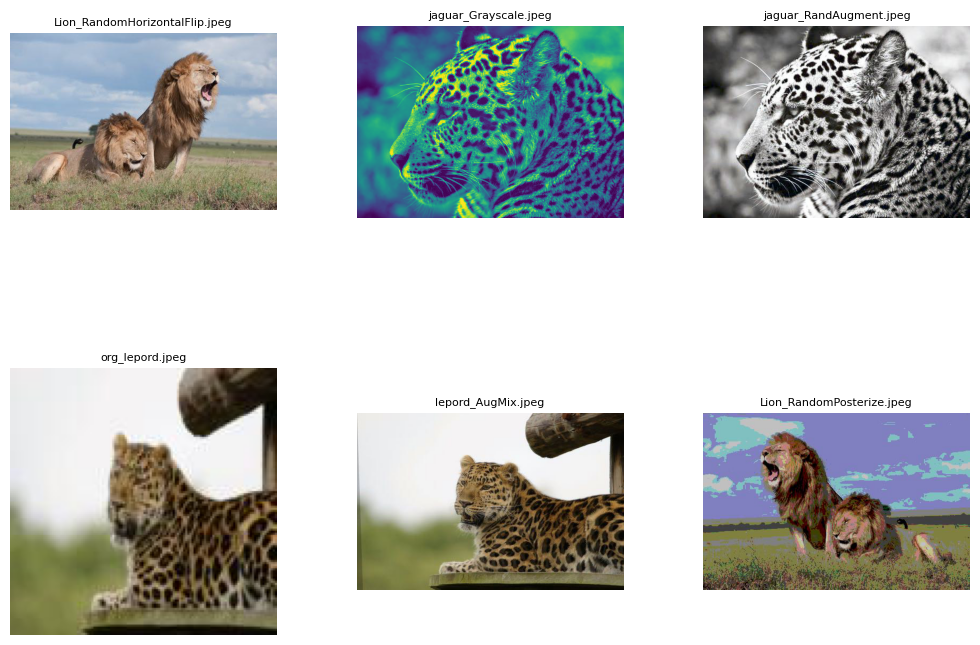

In [15]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

# Define the directory containing the images
image_dir = "/home/bcae/AI_Project/AI_project/augmented_data/image"

# Get a list of all jpeg files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpeg')]

# Randomly select 6 images
selected_files = random.sample(image_files, 6)

# Print the names of the selected images
print("Selected image names:", selected_files)

# Set up the subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Plot each selected image
for ax, image_file in zip(axes.flatten(), selected_files):
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    ax.imshow(image)
    ax.set_title(image_file, fontsize=8)
    ax.axis('off')

# Adjust layout to prevent titles from overlapping
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.90, hspace=0.3, wspace=0.3)
plt.show()


# Text

In [7]:
import pandas as pd
text_df = pd.read_csv("/home/bcae/AI_Project/AI_project/augmented_data/text/augmented_data.csv")


In [6]:
text_df.head(5)

,Sentence,Summary_synonym_replacement,Summary_add_noise,Summary_random_insertion,Summary_random_deletion,Summary_random_swap,Summary_paraphrasing,Summary_style_transfer_nmt,Summary_stochastic_text_generation,Summary_hierarchical_text_generation,Summary_masking,Summary_correct_grammar,Summary_generation,Summary_conditional_text_generation,Summary_bert_augmentation,Summary_combination,Summary_back_translation
0,good quality dog food,well character give_chase food,good quality dtg food,good a quality dog i w food,quality dog food,dog quality good food,undecomposed select hound intellectual_nourish...,GOOD QUALITY DOG FOOD,food quality good food,salutary intellectual_nourishment tail intelle...,good quality [MASK] food,correct grammar: good quality dog food,guter quality dog food,eng,good quality dog [unused200],good quality dog,good quality dog ​​food
1,not as advertised,not adenine push,not am advTrtjsed,w z p not as advertised,not as advertised,advertised as not,non angstrom_unit advertised,NOT AS ADVERTISED,not advertised advertised,publicise Eastern_Samoa not,[MASK] as advertised,correct grammar: not as advertised,NaN,generate response for: not as advertised,[unused88] as advertised,not as advertised,not as advertised
2,delight says it all,enthrall suppose information_technology whole,delight says it all,delight says a x t it all,delight says it all,delight says it all,revel say IT totally,DELIGHT SAYS IT ALL,delight says it all,pleasure all all pleasure,delight [MASK] [MASK] [MASK],delight says it all,delight says it all,delight says it all,delight [unused577] it all,delight says it,delight says it all
3,cough medicine,coughing medication,cough medicinw,cough b n g medicine,NaN,medicine cough,cough medicate,COUGH MEDICINE,cough medicine,coughing medicament,cough [MASK],correct grammar: cough medicine,cough medicine,NaN,[unused15] medicine,cough,cough medicine
4,great taffy,neat taffy,great thffW,great v z u taffy,great taffy,taffy great,smashing taffy,GREAT TAFFY,great great,gravid taffy,great taffy,correct grammar: great taffy,taffy,NaN,[unused664] taffy,great taffy,Great candy


## Sensor

In [14]:
import os
import pandas as pd

# Specify the directory containing the CSV files
directory = '/home/bcae/AI_Project/AI_project/augmented_data/sensor'

# List all files in the directory
files = os.listdir(directory)

# Filter out the CSV files
csv_files = [file for file in files if file.endswith('.csv')]

# Iterate over each CSV file
for csv_file in csv_files:
    # Construct the full file path
    file_path = os.path.join(directory, csv_file)
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Print the file name as the header
    print(f'File: {csv_file}')
    
    # Display the head of the DataFrame
    print(df.head(5))
    
    # Print a separator line
    print('-' * 80)

File: smoke_detection_iot_augmented_add_gaussian_noise.csv
          UTC  Fire Alarm  Temperature[C]  Humidity[%]  TVOC[ppb]   eCO2[ppm]  \
0  1654733331           0       20.006355    57.370411   0.008377  400.016900   
1  1654733332           0       20.005450    56.668118   0.000000  400.000000   
2  1654733333           0       20.015040    55.954282   0.000000  400.000000   
3  1654733334           0       20.038602    55.270083   0.000000  400.008897   
4  1654733335           0       20.067219    54.704013   0.000916  400.000236   

         Raw H2   Raw Ethanol  Pressure[hPa]     PM1.0     PM2.5     NC0.5  \
0  12306.006511  18519.999117     939.724859  0.000000  0.006957  0.000000   
1  12345.006106  18650.999986     939.737909  0.000000  0.000000  0.001456   
2  12373.989246  18763.996388     939.745502  0.000000  0.000000  0.002549   
3  12390.015008  18849.006574     939.747264  0.000000  0.003343  0.003335   
4  12402.997640  18920.999045     939.740756  0.016446  0.000000

# Audio is not visualised but the files are present in this location /home/bcae/AI_Project/AI_project/augmented_data/audio